# AMEX Default Prediction

## Set up

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import pyarrow
from sklearn import preprocessing
%load_ext autoreload
%autoreload 2

## Preprocessing - Supervised

In [2]:
from sklearn.model_selection import train_test_split


In [3]:
# global parameters
SAMPLE = True

In [25]:
# load parquet data
data = pd.read_parquet('dataset/train.parquet')


In [26]:
raw_labels = pd.read_csv('dataset/train_labels.csv')

In [27]:
# use a smaller subset for fast pipeline during testing
if SAMPLE:
    sample = raw_labels['customer_ID'][:10000]
    data = data[data['customer_ID'].isin(sample)]

In [53]:
# preprocessing
from src.data_preprocessing import create_features
X, y = create_features(data, raw_labels)

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state = 0)


## Supervised methods
### XG Boost

In [54]:
from sklearn.ensemble import GradientBoostingClassifier
from src.evaluation import *

### Evaluation Methods
We want to recreate the evaluation metric from the competition: https://www.kaggle.com/competitions/amex-default-prediction/overview/evaluation
For this, first we introduce two terms:

- Normalized Gini Coefficient (G). Here is was calculated from the AUC score using the formula
$$GINI = (2*AUC)-1 $$
- Default rate at 4% (D). This captures a Sensitivity/Recall statistic by calculating the portion of defaults in the highest-ranked 4% of predictions.
  
Using **G** and **D** our evaluaton metric **M** is found by:
$$M = 0.5 \cdot(G+D) $$

The best-performing models achieve scores of 0.80 in this metric, and we hope to achieve accuracy close to that. There appears to be some inconsistency with regards to the training and test data provided by AMEX, as the test data is not merely a random sample of the training data. Instead the test data covers not only a separate set of customers, but also a different time period, Initial results show the M score close to 93% in the validation set, but around 70% in the competition. Therefore, validation accuracy is not a true reflection of test accuracy in this setting.

### Model fitting

In [55]:
max_samples_training = -1
xgb = GradientBoostingClassifier()
xgb.fit(X_train[:max_samples_training], y_train[:max_samples_training])
print("finished training")


finished training


In [58]:
pred = xgb.predict_proba(X_val)
print("finished evaluating")

finished evaluating


Traditional Metrics:
    tp: 406, fp: 100, tn: 1382, fn: 112
     The precision score is  0.8023715415019763
     The recall score is  0.7837837837837838
     The accuracy score is  0.894
     F-Measure:  0.79296875
AUC Score: 0.9545250861040336
GINI Score: 0.9090501722080673
Default rate at 4%: 0.638996138996139
M: 0.7740231556021031


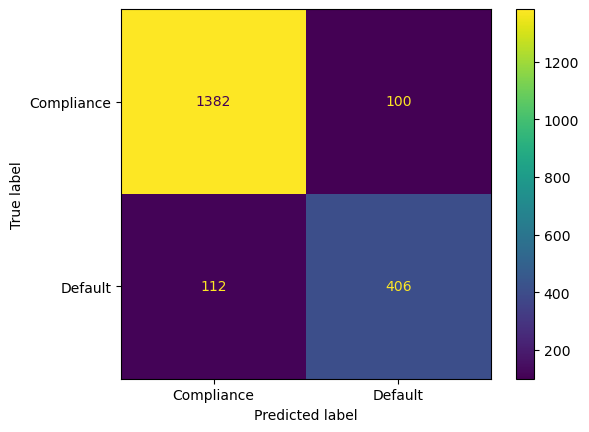

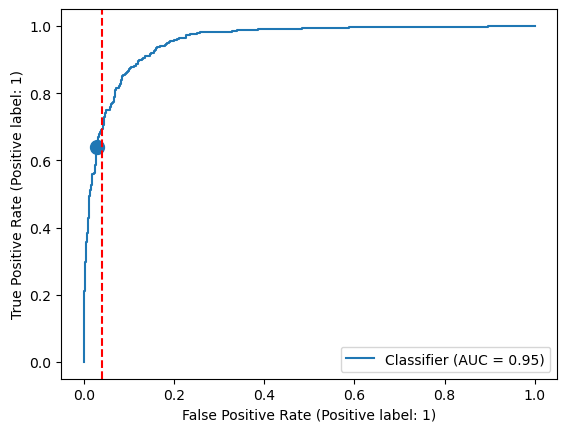

In [59]:
if SAMPLE:
    evaluate_model(y_val, pred, traditional = True)
    plot_confusion_matrix(y_val,pred)
    plot_GINI(y_val,pred)

## FeedForward Neural Network

In [65]:
from src.supervised import FeedForwardNN
import tensorflow as tf

net = FeedForwardNN(in_dims = len(X.columns))

s = tf.keras.backend.clear_session()
model=net.create_net()
model.summary()

model = net.compile_net(model)
print(model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                46400     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 46,465
Trainable params: 46,465
Non-trainable params: 0
_________________________________________________________________


In [67]:
from sklearn.preprocessing import StandardScaler
from scikeras.wrappers import KerasClassifier

batch_size = 64
epochs = 50
init_lr = 0.01

def lr_scheduler(epoch):
    new_lr = init_lr * 0.8 ** epoch
    print("Learning rate:", new_lr)
    return new_lr

history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_scheduler)],
    shuffle=True,
    verbose=1,
    initial_epoch=0, 
    validation_data=(X_val, y_val)
)
# score = model.evaluate(x_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])


Learning rate: 0.01
Epoch 1/50
125/125 [==============================] - 1s 5ms/step - loss: 0.4598 - auc: 0.8917 - val_loss: 0.2735 - val_auc: 0.9399 - lr: 0.0100
Learning rate: 0.008
Epoch 2/50
125/125 [==============================] - 0s 3ms/step - loss: 0.3000 - auc: 0.9282 - val_loss: 0.2610 - val_auc: 0.9430 - lr: 0.0080
Learning rate: 0.006400000000000001
Epoch 3/50
125/125 [==============================] - 0s 4ms/step - loss: 0.2573 - auc: 0.9461 - val_loss: 0.2528 - val_auc: 0.9495 - lr: 0.0064
Learning rate: 0.005120000000000001
Epoch 4/50
125/125 [==============================] - 0s 3ms/step - loss: 0.2550 - auc: 0.9472 - val_loss: 0.2438 - val_auc: 0.9528 - lr: 0.0051
Learning rate: 0.004096000000000001
Epoch 5/50
125/125 [==============================] - 0s 3ms/step - loss: 0.2503 - auc: 0.9494 - val_loss: 0.2451 - val_auc: 0.9486 - lr: 0.0041
Learning rate: 0.0032768000000000007
Epoch 6/50
125/125 [==============================] - 0s 3ms/step - loss: 0.2414 - auc: 0

In [77]:
pred_raw = model.predict(X_val)

pred_nn = np.concatenate([1-pred_raw, pred_raw],axis = 1)
evaluate_model(y_val, pred_nn, traditional = True)

63/63 [==============================] - 0s 2ms/step
Traditional Metrics:
    tp: 402, fp: 94, tn: 1388, fn: 116
     The precision score is  0.8104838709677419
     The recall score is  0.7760617760617761
     The accuracy score is  0.895
     F-Measure:  0.7928994082840235
AUC Score: 0.9532263611210979
GINI Score: 0.9064527222421959
Default rate at 4%: 0.6544401544401545
M: 0.7804464383411751


0.7804464383411751